#### <u> <font color=blue> Load Packages </font>  </u>

In [1]:
rm(list=ls())
library('Biobase')
library('limma')
library("biomaRt")
library("edgeR")
library('EnhancedVolcano')
library("clusterProfiler")
library("DOSE")
library("tibble")
library('org.Mm.eg.db')
library(enrichplot)
library(GOSemSim)
library(DOSE)
library(dplyr)
library(ggplot2)
library(stringr)
library(data.table)
library(tidyr)
library(GOplot)

PATH = paste(getwd(), sep = .Platform$file.sep)
PATH_DATA = paste(PATH, 'Data', sep = .Platform$file.sep)
PAPER_DATA = paste(PATH, 'Supplementary', sep = .Platform$file.sep)
options(repr.plot.width=6, repr.plot.height=6)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA


Loading required package: ggplot2

Loading required package: ggrepel

Registered S3

In [2]:
packageVersion('limma')
packageVersion("biomaRt")
packageVersion("edgeR")
packageVersion('EnhancedVolcano')
packageVersion("clusterProfiler")
packageVersion("DOSE")
packageVersion("tibble")
packageVersion('org.Mm.eg.db')

[1] ‘3.50.3’

[1] ‘2.50.3’

[1] ‘3.36.0’

[1] ‘1.12.0’

[1] ‘4.2.2’

[1] ‘3.20.1’

[1] ‘3.1.8’

[1] ‘3.14.0’

#### <u> <font color=blue> Download mouse gene annotations</font>  </u>

In [3]:
# ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")
# annot <- getBM(attributes =  c("ensembl_gene_id", "entrezgene_id", "mgi_symbol", "chromosome_name", "strand", "start_position", "end_position","gene_biotype"),
#                mart=ensembl)

# write.table(annot, paste(PATH_DATA, "Annotations.tsv", sep = .Platform$file.sep)  ,sep="\t",row.names=FALSE)
# dim(annot)

#### <u> <font color=blue> Load gene expression counts</font>  </u>

In [4]:
## Load expression data
counts <- read.delim("Data/WT-VitDdef-VDRKO-Th2/WT-VitDdef-VDRKO-Th2.tsv", row.names = 1)
colnames(counts) <- gsub("C57_BL6_","",colnames(counts))
colnames(counts) <- substr(colnames(counts), start = 1, stop = 11)
colnames(counts) <- gsub("\\.","-",colnames(counts))
head(counts)
dim(counts)

samples <- colnames(counts)
nsamples <- length(samples)

,S-001780499,S-001780493,S-001780494,S-001780497,S-001780490,S-001780491,S-001780496,S-001780495,S-001780492,S-001780498,S-001780487,S-001780483,S-001780489,S-001780500,S-001780488,S-001780482,S-001780481
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,1951,3194,2150,1964,5310,5254,1826,2063,5446,1578,4223,2007,2592,5543,5165,1859,1778
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
ENSMUSG00000000028,300,453,117,278,1044,606,260,273,668,249,897,391,431,862,926,341,322
ENSMUSG00000000031,6,0,10,10,0,2,4,4,0,13,0,2,0,14,1,1,0
ENSMUSG00000000037,1,10,2,5,15,16,3,4,16,1,17,1,8,9,14,6,7
ENSMUSG00000000049,0,2,1,2,1,0,0,0,2,0,0,1,0,6,3,1,0


[1] 49671    17

#### <u> <font color=blue>Remove duplicates and subset annotations</font>  </u>

In [5]:
annot <- read.csv(file =  paste(PATH_DATA, "Annotations.tsv", sep = .Platform$file.sep), sep = '\t', header = TRUE)

annot <- annot[!duplicated(annot$ensembl_gene_id), ]
rownames(annot) <- annot$ensembl_gene_id
annot <- annot[rownames(counts),]
head(annot)
dim(annot)

,ensembl_gene_id,entrezgene_id,mgi_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSMUSG00000000001,ENSMUSG00000000001,14679,Gnai3,3,-1,108014596,108053462,protein_coding
ENSMUSG00000000003,ENSMUSG00000000003,54192,Pbsn,X,-1,76881507,76897229,protein_coding
ENSMUSG00000000028,ENSMUSG00000000028,12544,Cdc45,16,-1,18599197,18630737,protein_coding
ENSMUSG00000000031,ENSMUSG00000000031,14955,H19,7,-1,142129262,142131917,lncRNA
ENSMUSG00000000037,ENSMUSG00000000037,107815,Scml2,X,1,159865521,160041209,protein_coding
ENSMUSG00000000049,ENSMUSG00000000049,11818,Apoh,11,1,108234180,108305222,protein_coding


[1] 49671     8

#### <u> <font color=blue> Load metadata </font>  </u>

In [6]:
## Load meta data
meta <- read.csv("Data/WT-VitDdef-VDRKO-Th2/metadata_Th2-WT-Def-KO.csv", row.names=1)
meta <- meta[colnames(counts),]
meta$group <- paste(meta$genotype, meta$diet, sep="_")
meta$group<-gsub(" ", "_",meta$group)
meta$group<-gsub("-", "_",meta$group)
meta$diet<-gsub(" ", "_",meta$diet)
meta$diet<-gsub("-", "_",meta$diet)
meta$Batch <- interaction( "batch", meta$Batch, sep = "")

head(meta)
dim(meta)

,condition,genotype,diet,Genotype,Batch,group
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>
S-001780499,Th2,Knock out,Rescue,VDR-KO,batch2,Knock_out_Rescue
S-001780493,Th2,WT,Vit_D_deficient,Wildtype,batch2,WT_Vit_D_deficient
S-001780494,Th2,knock out,Rescue,VDR-KO,batch1,knock_out_Rescue
S-001780497,Th2,Knock out,Rescue,VDR-KO,batch2,Knock_out_Rescue
S-001780490,Th2,WT,Vit_D_deficient,Wildtype,batch1,WT_Vit_D_deficient
S-001780491,Th2,WT,Vit_D_deficient,Wildtype,batch1,WT_Vit_D_deficient


[1] 17  6

In [7]:
print(paste('Vit.D deficient diet: ', dim(meta[meta[,'diet']=='Vit_D_deficient',])[1]))
print(paste('Control: ', dim(meta[meta[,'diet']=='regular',])[1]))

[1] "Vit.D deficient diet:  7"
[1] "Control:  3"


### <u> <font color=blue> Normalize counts data </font>  </u>

In [8]:
x <- DGEList(counts)
dim(x)

[1] 49671    17

In [9]:
## Store meta information in x
x$genes <- annot
samplenames <- rownames(meta)

## Group
group <- meta$group
x$samples$group <- meta$group

## Genotypes
genotype <- meta$Genotype
x$samples$genotype <- meta$Genotype

## Batch information
lane <- meta$Batch
x$samples$lane <- lane

# head(x)

In [10]:
## Convert counts to cpm and log-cpm

cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)

#summary(lcpm)


[1] 9.946097 8.526526

In [11]:
## Removing genes with lowly expressed genes
table(rowSums(x$counts==0)==nsamples)



FALSE  TRUE 
37452 12219 

In [12]:
## Larger the library size, lower the CPM cutoff and vice versa
keep.exprs <- filterByExpr(x, group=group)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
x <- calcNormFactors(x, method = "TMM")
dim(x)

[1] 14013    17

### <u> <font color=blue> Run Limma </font>  </u>

In [13]:
# Create design matrix for the study

design <- model.matrix(~0 + diet + Batch, data = meta) #+Genotype
colnames(design) <- gsub("group", "", colnames(design))
colnames(design) <- gsub("Genotype", "", colnames(design))
colnames(design) <- gsub("diet", "", colnames(design))
colnames(design) <- gsub("Batch", "", colnames(design))

# Count the number of samples modeled by each coefficient
colSums(design)

design

regular          Rescue Vit_D_deficient          batch2 
              3               7               7               9

,regular,Rescue,Vit_D_deficient,batch2
S-001780499,0,1,0,1
S-001780493,0,0,1,1
S-001780494,0,1,0,0
S-001780497,0,1,0,1
S-001780490,0,0,1,0
S-001780491,0,0,1,0
S-001780496,0,1,0,1
S-001780495,0,1,0,1
S-001780492,0,0,1,1
S-001780498,0,1,0,1


In [14]:
cm <- makeContrasts(VitD_deficientvsControl =  Vit_D_deficient - regular,
                    #Vit_D_KOvsReg = Rescue - regular,
                   levels = design)

cm

,VitD_deficientvsControl
regular,-1
Rescue,0
Vit_D_deficient,1
batch2,0


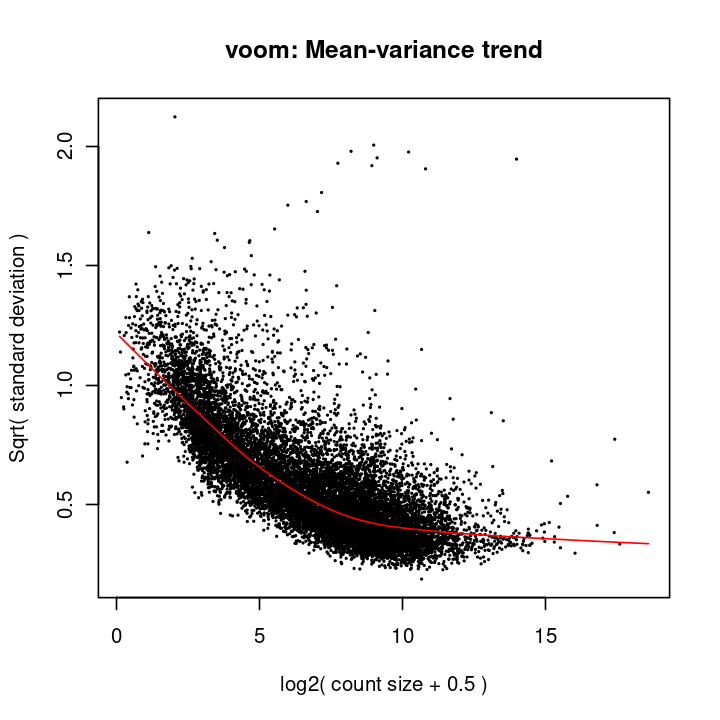

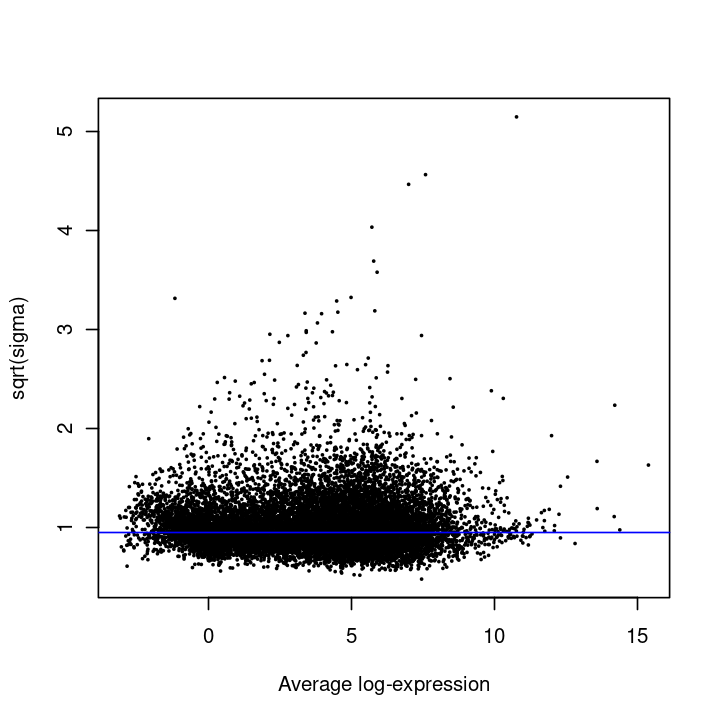

In [15]:
v <- voom(x, design, plot=TRUE)
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=cm)
fit2 <- eBayes(vfit)
plotSA(fit2)

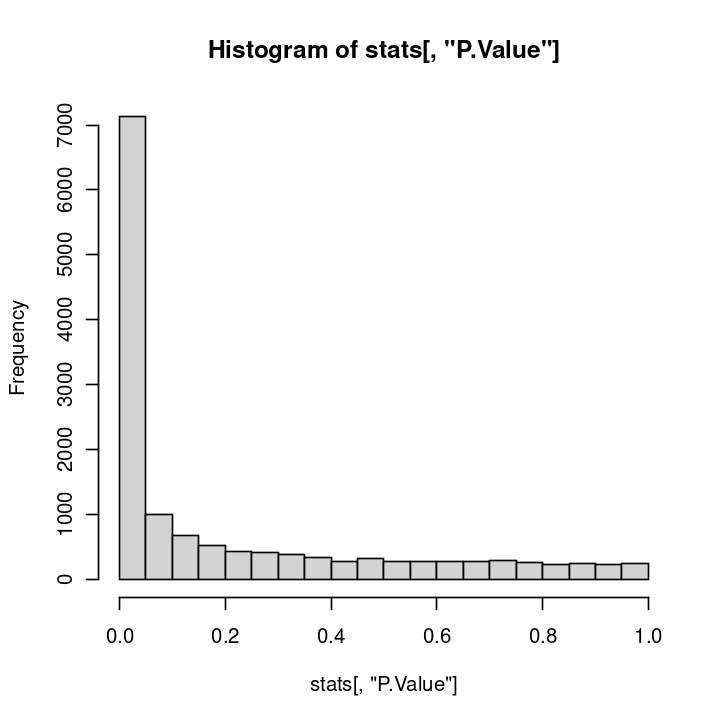

In [16]:
# Obtain the summary statistics for every gene
stats <- topTable(fit2, number = nrow(fit2), sort.by = "none")

# Plot a histogram of the p-values
hist(stats[, "P.Value"])

In [17]:
results <- decideTests(fit2[,'VitD_deficientvsControl'],  p.value = 0.05)
summary(results)

       VitD_deficientvsControl
Down                      2633
NotSig                    7845
Up                        3535

In [18]:
down_genes = summary(results)['Down','VitD_deficientvsControl']
up_genes = summary(results)['Up','VitD_deficientvsControl']

# res <- topTable(fit2, coef='VitD_deficientvsControl', number=Inf, sort.by='p',  p.value = 0.05, lfc = 1.585)#, lfc = 2)

# works
res <- topTable(fit2, coef='VitD_deficientvsControl', number=Inf, sort.by='p',  p.value = 0.01, lfc = 1.585)#, lfc = 25

# res <- topTable(fit2, coef='VitD_deficientvsControl', number=Inf, sort.by='p',  p.value = 0.05, lfc = 1.0)#, lfc = 25

## Differentially expressed genes
de_genes <- head(res, up_genes + down_genes)

fcvals_up <- de_genes[de_genes['logFC']> 0,]
fcvals_down <- de_genes[de_genes['logFC']< 0,]

dim(fcvals_up)
dim(fcvals_down)

[1] 491  14

[1] 395  14

In [19]:
file_name = paste(PAPER_DATA, 'Tab_S7.csv', sep = .Platform$file.sep)
write.csv(de_genes[,c('ensembl_gene_id','entrezgene_id','mgi_symbol','gene_biotype',
           'logFC','AveExpr','t','P.Value','adj.P.Val','B')],file_name)#, row.names=FALSE)

In [20]:
## Save normalized gene expression of differentially expressed genes
fname = paste(PAPER_DATA, 'lcpm_vitd_def.csv', sep = .Platform$file.sep)
write.csv(rownames(lcpm), fname)


In [21]:
de_plot_genes <- lcpm[c(rownames(fcvals_up), rownames(fcvals_down)),]
de_plot_genes <- de_plot_genes[,rownames(meta[meta[,'Genotype']=='Wildtype',])]

dim(de_plot_genes)
file_name = paste(PAPER_DATA,'de_genes_vitd_def.csv' , sep = .Platform$file.sep)
# write.csv(de_plot_genes,'de_genes_vitd_def.csv')
write.csv(de_plot_genes,file_name)

[1] 886  10

In [22]:
# cat(rownames(fcvals_down))
'Vdr' %in% annot[rownames(fcvals_up) ,]$mgi_symbol
'Vdr' %in% annot[rownames(fcvals_down),]$mgi_symbol

[1] FALSE

[1] TRUE

In [23]:
dim(fcvals_up)
dim(fcvals_down)

cat(sort(fcvals_up$mgi_symbol))
writeLines('\n')
writeLines('##############################################################################################################################################')
writeLines('\n')
cat(sort(fcvals_down$mgi_symbol))


[1] 491  14

[1] 395  14

1110002L01Rik 1700021A07Rik 1700028J19Rik 1810024B03Rik 1810062O18Rik 2410006H16Rik 2610035D17Rik 2610507I01Rik 2810002D19Rik 2810025M15Rik 3830403N18Rik 4833407H14Rik 4930509E16Rik 5330426L24Rik 5830444B04Rik 5830468F06Rik 6330403K07Rik 6330549D23Rik 9130008F23Rik 9230114K14Rik 9330175E14Rik 9430091E24Rik A230072E10Rik A730017L22Rik AA467197 Abcb10 Abcc4 Abcg3 Acot2 Adamtsl3 Adcy3 Aen Agap1 AI506816 Ajuba Akr1c12 Aldh1l2 Alg8 Amigo1 Angpt1 Angptl6 Ank Ankrd29 Ankrd6 Anxa3 Apbb2 Apobec3 Apol7e App Ar Arhgap19 Arhgap20 Arhgap31 Arhgdig Arhgef5 Arl2bp Arrdc4 Atad3aos Atp5mc1 Atp8b4 Avil Avpi1 B3galnt2 B4galnt2 Batf3 Bax Bbc3 BC023719 Bcl2a1b Bend6 Bloc1s2-ps Brd3os C920006O11Rik Cabp1 Cacna1a Calr3 Camk2b Ccdc122 Ccdc171 Ccdc184 Ccdc40 Ccl17 Ccl27a Ccl3 Ccl4 Cd46 Cd59a Cd80 Cd8b1 Cdc42bpb Cdh11 Cdkn1a Cfap74 Cgref1 Chl1 Ciart Cldnd2 Clec2l Clec7a Clybl Coro2a Cox6a2 Cox6b2 Cpq Crhbp Crip2 Crtam Crybg3 Cryzl2 Csf2 Cspg5 Ctbp2 Cth Cxcr3 Cyb561 Cyb5r2 Cyp4v3 D030028A08Rik D130017N08Rik Dcdc

In [24]:
down <- c(annot[rownames(fcvals_down),]$mgi_symbol)
up <- c(annot[rownames(fcvals_up) ,]$mgi_symbol)

library(stringr)
vitd_target <- str_to_title(c('VDR', 'VDRE', 
              ## GO
              'CYP2R1','CYP24A1', 'CYP27A1', 'CYP27B1', 'ENPP1', 'FGF23','FGFR1', 'FGFR4','GC','GFI1','IFNG','LRP2','NFKB1','SNAI1','SNAI2','TNF', 
              ## WikiPathways
              'ABCB1', 'ABCA11', 'ABCD1', 'ADAMTS5', 'ADGRE5', 'ADRA1B', 'ADRB2', 'ALOX5', 'ALPG', 'ALPI',
              'ASAP2', 'ATP2B1', 'ATP2C2', 'BCL6', 'BDKRB1', 'BGLAP', 'BMP6', 'BTLA', 'CA9', 'CALB1', 'CAMP',
              'CASP14', 'CASP5', 'CBS', 'CCNC', 'CCND1', 'CCNE1', 'CD14', 'CD200', 'CD40', 'CD9', 'CDC34', 'CDK2',
              'CDKAL1', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDX2', 'CEACAM1', 'CEBPA',
              'CLDN2', 'CLEC16A', 'CLMN', 'CLPTM1L', 'COLEC11', 'CRACR2A', 'CRACR2B', 'CREG2', 'CST1', 'CST6', 
              'CTLA4', 'CYP1A1', 'CYP24A1', 'CYP27B1', 'CYP2B6', 'CYP2C9', 'CYP2D6', 'CYP2S1', 'CYP3A4', 'CYP3A5',
              'CYP7A1', 'COL13A1', 'DACT2', 'DEFB109C', 'DEFB132', 'DEFB4A', 'DND1', 'DNER', 'DUSP10', 'EFNA5',
              'EPHB4', 'FGF23', 'FOXO1', 'G0S2', 'G6PD', 'GADD45A', 'GXYLT2', 'HIF1A', 'HILPDA', 'HLA-DQA1', 'HLA-DRB1',
              'HNF1A', 'HSD17B2', 'ID1', 'ID4', 'IGFBP1', 'IGFBP3', 'IGFBP5', 'IGSF9B', 'IL12A', 'IL1RL1', 'IL25', 'IRF4',
              'IRF5', 'IRF8', 'ITGAM', 'JUNB', 'KL', 'KLF4', 'KLK6', 'KNG1', 'KRT13', 'KRT16', 'KRT34', 'KRT38', 'KRT71',
              'KRTAP10-2', 'KRTAP10-4', 'KRTAP10-7', 'KRTAP10-9', 'KRTAP12-2', 'KRTAP4-1', 'KRTAP5-1', 'KRTAP5-4', 'KRTAP8-1',
              'LCE1D', 'LCE1F', 'LCE2B', 'LGALS9', 'LPGAT1', 'LRP5', 'LRRC25', 'LRRC8A', 'Ligand', 'MED9', 'MEG8', 'MX2', 
              'MXD1', 'MYC', 'MYO9B', 'NFATC2', 'NINJ1', 'NOX1', 'NRIP1', 'ORM1', 'ORM2', 'PNOC', 'PPARD', 'PRDM1', 'PRKCQ',
              'PTGER4', 'PTH', 'PTHLH', 'RASGRP1', 'RXRA', 'S100A2', 'S100A4', 'S100A6', 'S100A8', 'S100A9', 'S100G', 'SALL4',
              'SATB1', 'SEMA3B', 'SERPINB1', 'SFRP1', 'SLC2A4', 'SLC34A2', 'SLC37A2', 'SLC8A1', 'SOSTDC1', 'SPP1', 'SPRR1B', 'STAM', 
              'STEAP4', 'STS', 'SULT1C2', 'SULT2A1', 'TGFB1', 'TGFB2', 'THBD', 'TIMP2', 'TIMP3', 'TNFAIP3', 'TNFRSF11B', 'TNFSF11',
              'TNFSF4', 'TPM1', 'TRAK1', 'TREM1', 'TRPV5', 'TRPV6','VDR', 'ZNF257'))


print('VitD deficient')
table(vitd_target[match(up, vitd_target)])

print('Control')
table(vitd_target[match(down, vitd_target)])


[1] "VitD deficient"



Cdkn1a   Dnd1   Ifng Igsf9b Tnfsf4 
     1      1      1      1      1 

[1] "Control"



Cyp1a1 Cyp2s1 Dusp10    Id1 Il1rl1    Vdr 
     1      1      1      1      1      1 

### Volcano plot

In [25]:
exprs <- lcpm 
pData <- meta
all(rownames(pData)==colnames(exprs))

annot <- annot[rownames(lcpm),]
genes_of_interest <- intersect(rownames(exprs),rownames(annot))
all(rownames(exprs[genes_of_interest,])==rownames(annot[genes_of_interest,]))

# Create ExpressionSet object
eset <- ExpressionSet(assayData =  exprs[genes_of_interest,],
                     phenoData = AnnotatedDataFrame(pData),  #,
                     featureData = AnnotatedDataFrame(annot[genes_of_interest,]) )

# View the number of features (rows) and samples (columns)
dim(eset)

[1] TRUE

[1] TRUE

Features  Samples 
   45842       17

In [26]:
genes <- c('Cdkn1a', 'Dnd1',  'Ifng','Igsf9b', 'Tnfsf4', 'Cyp11a1', 'Cyp1a1', 'Cyp2s1','Dusp10','Id1','Il1rl1','Vdr')
res <- topTable(fit2, coef='VitD_deficientvsControl', number=Inf, sort.by='p')#, lfc = 0.58, p.value = 0.05)

lab_italics <- paste0("italic('", fData(eset)[rownames(res),]$mgi_symbol, "')")
selectLab_italics = paste0(
    "italic('",genes, "')")

pdf("Figures/Fig5C.pdf", width = 10, height = 10, bg='transparent')
#down <- '#c3d2bd'
down <- "#9ca897" #"#9ca897"
up <-  '#7cb5b0'
de1_symbols <- res
keyvals <- ifelse(de1_symbols$logFC < -1.585  & de1_symbols$adj.P.Val < 0.05, down, ifelse(de1_symbols$logFC > 1.585  & de1_symbols$adj.P.Val < 0.05, up, '#4D4D4D'))
keyvals[is.na(keyvals)] <- '#4D4D4D'
names(keyvals)[keyvals == down] <- 'Control' #'Down-regulated'
names(keyvals)[keyvals == '#4D4D4D'] <- 'NS'
names(keyvals)[keyvals == up] <-  'Vit-D deficiency'#'Up-regulated'

EnhancedVolcano(res,
   lab = lab_italics,
    x = 'logFC',
    y = 'adj.P.Val',
    selectLab = selectLab_italics,
    xlab = bquote(~Log[2]~ 'FC'),
    pCutoff = 0.05,
    FCcutoff = 1.58,
    pointSize = 2.0,
    labSize = 10.0, ## gene names
    xlim = c(-4, 4),
    ylim = c(0, -log10(10e-13)),
    labCol = 'black',
    labFace = 'bold',
    boxedLabels = TRUE,
    parseLabels = TRUE,
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'bottom',
    legendLabSize = 20, # bottom legend size
    axisLabSize = 25, # 
    legendIconSize = 10.0,
    drawConnectors = TRUE,
    caption = '',
    widthConnectors = 1,
    title = '', # 'Vitamin D in VDAART',
    subtitle  = "",
    border = 'full', borderWidth = 1, borderColour = 'grey',
    colConnectors = 'black') 

dev.off()




png 
  2

## GO enrichment

In [27]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 100) 

In [28]:
# https://wencke.github.io/
de_genes_list <- fcvals_up #rbind(fcvals_down, fcvals_up)
de_genes_list['mgi_symbol'] <- annot[rownames(de_genes_list), 'ensembl_gene_id']
genelist <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist) <- NULL
names(genelist)[1] <- "ID"
dim(genelist)


de_genes_list['mgi_symbol'] <- annot[rownames(de_genes_list), 'mgi_symbol'] 
genelist_symbol <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist_symbol) <- NULL
names(genelist_symbol)[1] <- "ID"
dim(genelist_symbol)



[1] 491   7

[1] 491   7

## GO BP

In [29]:
go_all <- enrichGO(genelist$ID, 
                   OrgDb = "org.Mm.eg.db", 
                   keyType       = 'ENSEMBL',
                ont           = "all",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                minGSSize = 10, 
                  maxGSSize = 250,
                   universe = annot[ rownames(lcpm),'ensembl_gene_id'],
                    readable      = TRUE
                  )

In [30]:
## BP
ego <- filter(go_all, ONTOLOGY == 'BP') 
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S8_bp_up.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)

[1] 184  11

## CC

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


png 
  2

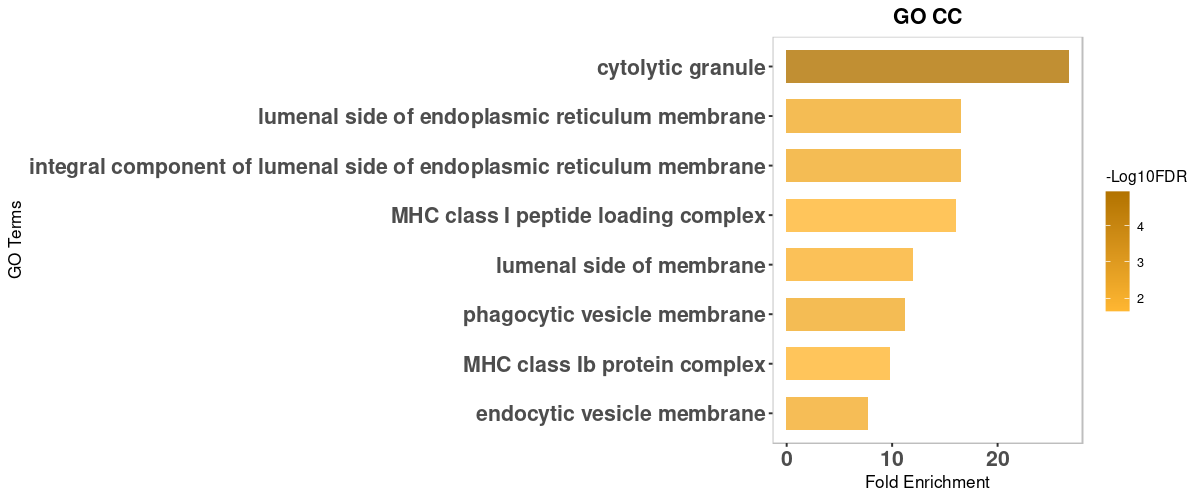

In [31]:
# pdf("Figures/kegg_down.pdf", width = 7, height = 4)
size = 12
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 100) 
# head(data.frame(go))
go <- go_all[go_all$ONTOLOGY == 'CC'] ## select BP

go <- go[1:10,] ## select top 10

li_gr = c()
li_br = c()
for (x in go$GeneRatio) {
  li_gr <- append(li_gr, (eval(parse(text=x))) )
}

for (x in go$BgRatio) {
  li_br <- append(li_br, (eval(parse(text=x))) )
}
tmp <- data.frame(go)
tmp$FE <- li_gr/li_br ## Fold enrichment
tmp$log10adjpval <- -log10(tmp$p.adjust)
tmp$rankFDR <- c(seq(1, nrow(tmp)))
tmp <- tmp[order( -tmp$FE),]
tmp$rankFE <- seq(1, nrow(tmp))
tmp$rank <- (tmp$rankFDR + tmp$rankFE)/2
tmp <- tmp[order(-tmp$log10adjpval),]
go <- tmp[order( tmp$rankFE),]



EC <- data.frame(Category  = go$ONTOLOGY,
                 ID = go$ID, 
                 Term =  go$Description,
                 Genes =  gsub("/",", ", go$geneID),
                adj_pval =  go$p.adjust,
                 fold.enrichment = go$FE,
                count = go$Count)

EC['-Log10FDR'] = -log10(EC$adj_pval)


# EC[1:8,]

EC <- EC[1:8,]
EC <- EC[order(EC$fold.enrichment),]
EC$Term <- factor(EC$Term, levels = EC$Term)


pdf("Figures/Fig5F.pdf", width = 11, height = 4)
library("stringr") 
p <- ggplot(data = EC, aes(x = Term, y = fold.enrichment, fill = `-Log10FDR`)) +
    # scale_fill_gradient(low = "#ffbc32", high = "#cc8900") +
    scale_fill_gradient(low ="#ffb732", high = "#b27300")+ # "#ffbe46", high = "#996d1e") +
    geom_bar(width = 0.65, stat = "identity", alpha = 0.8) +
    coord_flip() + 
   scale_y_continuous(name="Fold Enrichment") +
   scale_x_discrete(name="GO Terms") +
   theme(axis.text.x = element_text(face="bold", #color="#008000",
                               size=15, angle=0),
           axis.text.y = element_text(face="bold", #color="#008000",
                           size=15, angle=0),
           panel.background = element_blank(),
           panel.border = element_rect(colour = "grey", fill=NA, size=0.5),#element_rect(colour = "grey", fill=NA, size=0),
           plot.title = element_text(size=15, face='bold', hjust = 0.5),
           axis.title.y = element_text(size = size),
           axis.title.x = element_text(size = size),
     ) + ggtitle("GO CC") +  xlab("GO TERMS") + 
  ylab("Fold Enrichment") 

p 


dev.off()

p 

In [32]:
## BP
ego <- filter(go_all, ONTOLOGY == 'CC') #filter(go_all, Description %in% EC$Term) #[EC$count >= 20,]#
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S8_cc_up.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)


[1] 13 11

In [33]:
head(as.data.frame(ego), 10)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044194,CC,GO:0044194,cytolytic granule,6/419,12/22408,3.465276e-08,1.126215e-05,9.994584e-06,Gzmb/Gzmc/Prf1/Gzmd/Gzmf/Gzmg,6
GO:0030670,CC,GO:0030670,phagocytic vesicle membrane,5/419,24/22408,7.074563e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3/Anxa3,5
GO:0071556,CC,GO:0071556,integral component of lumenal side of endoplasmic reticulum membrane,4/419,13/22408,7.537279e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0098553,CC,GO:0098553,lumenal side of endoplasmic reticulum membrane,4/419,13/22408,7.537279e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0030666,CC,GO:0030666,endocytic vesicle membrane,6/419,42/22408,1.223685e-04,7.953955e-03,7.058733e-03,H2-K1/H2-D1/H2-Q7/Smo/H2-T3/Anxa3,6
GO:0000932,CC,GO:0000932,P-body,8/419,83/22408,1.621186e-04,8.781427e-03,7.793072e-03,Psmc2/Ajuba/Trim30a/Trim30d/Trim12a/Trim5/Apobec3/Trim71,8
GO:0098576,CC,GO:0098576,lumenal side of membrane,4/419,18/22408,2.995204e-04,1.390630e-02,1.234114e-02,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0031901,CC,GO:0031901,early endosome membrane,8/419,97/22408,4.735792e-04,1.923916e-02,1.707378e-02,H2-K1/H2-D1/H2-Q7/Zfyve9/Marchf8/H2-T3/Egfr/Tmem163,8
GO:0032398,CC,GO:0032398,MHC class Ib protein complex,4/419,22/22408,6.748837e-04,2.295754e-02,2.037366e-02,H2-K1/H2-D1/H2-Q7/H2-T3,4


> ## MF

png 
  2

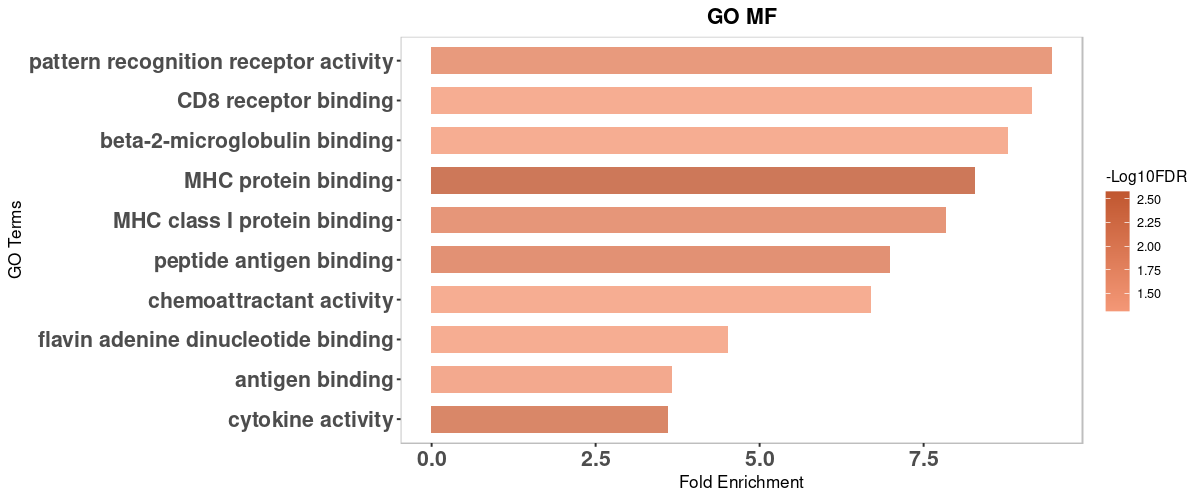

In [34]:
# pdf("Figures/kegg_down.pdf", width = 7, height = 4)
size = 12
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 100) 


# head(data.frame(go))
go <- go_all[go_all$ONTOLOGY == 'MF'] ## select BP
go <- go[1:10,] ## select top 10

li_gr = c()
li_br = c()
for (x in go$GeneRatio) {
  li_gr <- append(li_gr, (eval(parse(text=x))) )
}

for (x in go$BgRatio) {
  li_br <- append(li_br, (eval(parse(text=x))) )
}
tmp <- data.frame(go)
tmp$FE <- li_gr/li_br ## Fold enrichment
tmp$log10adjpval <- -log10(tmp$p.adjust)
tmp$rankFDR <- c(seq(1, nrow(tmp)))
tmp <- tmp[order( -tmp$FE),]
tmp$rankFE <- seq(1, nrow(tmp))
tmp$rank <- (tmp$rankFDR + tmp$rankFE)/2
tmp <- tmp[order(-tmp$log10adjpval),]
# tmp[order( tmp$rankFE),]
go <- tmp[order( tmp$rankFE),]


EC <- data.frame(Category  = go$ONTOLOGY,
                 ID = go$ID, 
                 Term =  go$Description,
                 Genes =  gsub("/",", ", go$geneID),
                adj_pval =  go$p.adjust,
                 fold.enrichment = go$FE,
                count = go$Count)

EC['-Log10FDR'] = -log10(EC$adj_pval)



EC <- EC[order(EC$fold.enrichment),]
EC$Term <- factor(EC$Term, levels = EC$Term)


pdf("Figures/Fig5G.pdf", width = 7, height = 4)
library("stringr") 
p <- ggplot(data = EC, aes(x = Term, y = fold.enrichment, fill = `-Log10FDR`)) +
    scale_fill_gradient(low = "#f49877", high = "#c05730") +
    geom_bar(width 
             = 0.65, stat = "identity", alpha = 0.8) +
    coord_flip() + 
   scale_y_continuous(name="Fold Enrichment") +
   scale_x_discrete(name="GO Terms") +
   theme(axis.text.x = element_text(face="bold", #color="#008000",
                               size=15, angle=0),
           axis.text.y = element_text(face="bold", #color="#008000",
                           size=15, angle=0),
           panel.background = element_blank(),
           panel.border = element_rect(colour = "grey", fill=NA, size=0.5),
           plot.title = element_text(size=15, face='bold', hjust = 0.5),
           axis.title.y = element_text(size = size),
           axis.title.x = element_text(size = size),
     ) + ggtitle("GO MF") +  xlab("GO TERMS") + 
  ylab("Fold Enrichment") 

p #+ scale_x_discrete(labels = function(x) str_wrap(x, width = 6))


dev.off()

p 

In [35]:
head(as.data.frame(ego), 10)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044194,CC,GO:0044194,cytolytic granule,6/419,12/22408,3.465276e-08,1.126215e-05,9.994584e-06,Gzmb/Gzmc/Prf1/Gzmd/Gzmf/Gzmg,6
GO:0030670,CC,GO:0030670,phagocytic vesicle membrane,5/419,24/22408,7.074563e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3/Anxa3,5
GO:0071556,CC,GO:0071556,integral component of lumenal side of endoplasmic reticulum membrane,4/419,13/22408,7.537279e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0098553,CC,GO:0098553,lumenal side of endoplasmic reticulum membrane,4/419,13/22408,7.537279e-05,6.124039e-03,5.434775e-03,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0030666,CC,GO:0030666,endocytic vesicle membrane,6/419,42/22408,1.223685e-04,7.953955e-03,7.058733e-03,H2-K1/H2-D1/H2-Q7/Smo/H2-T3/Anxa3,6
GO:0000932,CC,GO:0000932,P-body,8/419,83/22408,1.621186e-04,8.781427e-03,7.793072e-03,Psmc2/Ajuba/Trim30a/Trim30d/Trim12a/Trim5/Apobec3/Trim71,8
GO:0098576,CC,GO:0098576,lumenal side of membrane,4/419,18/22408,2.995204e-04,1.390630e-02,1.234114e-02,H2-K1/H2-D1/H2-Q7/H2-T3,4
GO:0031901,CC,GO:0031901,early endosome membrane,8/419,97/22408,4.735792e-04,1.923916e-02,1.707378e-02,H2-K1/H2-D1/H2-Q7/Zfyve9/Marchf8/H2-T3/Egfr/Tmem163,8
GO:0032398,CC,GO:0032398,MHC class Ib protein complex,4/419,22/22408,6.748837e-04,2.295754e-02,2.037366e-02,H2-K1/H2-D1/H2-Q7/H2-T3,4


In [36]:
## MF
ego <- filter(go_all, ONTOLOGY == 'MF') #filter(go_all, Description %in% EC$Term) #[EC$count >= 20,]#
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S8_mf_up.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)


[1] 13 11

> *Circular barplot*

In [37]:
# head(data.frame(go))
go <- go_all[go_all$ONTOLOGY == 'BP'] ## select BP
go <- go[1:10,] ## select top 10

li_gr = c()
li_br = c()
for (x in go$GeneRatio) {
  li_gr <- append(li_gr, (eval(parse(text=x))) )
}

for (x in go$BgRatio) {
  li_br <- append(li_br, (eval(parse(text=x))) )
}
tmp <- data.frame(go)
tmp$FE <- li_gr/li_br ## Fold enrichment
tmp$log10adjpval <- -log10(tmp$p.adjust)
tmp$rankFDR <- c(seq(1, nrow(tmp)))
tmp <- tmp[order( -tmp$FE),]
tmp$rankFE <- seq(1, nrow(tmp))
tmp$rank <- (tmp$rankFDR + tmp$rankFE)/2
tmp <- tmp[order(-tmp$log10adjpval),]
go <- tmp[order( tmp$rankFE),]

# go

EC <- data.frame(Category  = go$ONTOLOGY,
                 ID = go$ID, 
                 Term =  go$Description,
                 Genes =  gsub("/",", ", go$geneID),
                adj_pval =  go$p.adjust,
                 fold.enrichment = go$FE,
                count = go$Count)

EC['-Log10FDR'] = -log10(EC$adj_pval)

dim(EC)
EC[1:8,]

[1] 10  8

,Category,ID,Term,Genes,adj_pval,fold.enrichment,count,-Log10FDR
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,BP,GO:0001913,T cell mediated cytotoxicity,"H2-K1, H2-D1, H2-T10, H2-Q7, Serpinb9, H2-T3, Gzmb, Il23a, Serpinb9b, Klrd1, Emp2, Prf1",1.423843e-06,9.812924,12,5.846538
2,BP,GO:0042267,natural killer cell mediated cytotoxicity,"Crtam, Serpinb9, Havcr2, Gzmb, Serpinb9b, Klrd1, Klrk1, Gzmc, Gzmd, Gzmf, Gzmg, Klrc1",8.808758e-06,8.303244,12,5.055085
3,BP,GO:0031343,positive regulation of cell killing,"H2-K1, H2-D1, H2-T10, H2-Q7, Crtam, H2-T3, Il23a, Ifng, Klrd1, Klrk1, Prf1, Clec7a, Klrc1",8.808758e-06,7.385517,13,5.055085
4,BP,GO:0031341,regulation of cell killing,"H2-K1, H2-D1, H2-T10, H2-Q7, Crtam, Serpinb9, Havcr2, Cd59a, H2-T3, Il23a, Serpinb9b, Ifng, Klrd1, Klrk1, Prf1, Clec7a, Klrc1",4.868049e-07,6.898560,17,6.312645
5,BP,GO:0001909,leukocyte mediated cytotoxicity,"H2-K1, H2-D1, H2-T10, H2-Q7, Crtam, Serpinb9, Havcr2, H2-T3, Gzmb, Il23a, Serpinb9b, Klrd1, Klrk1, Emp2, Gzmc, Prf1, Gzmd, Gzmf, Gzmg, Klrc1",2.729973e-08,6.831783,20,7.563842
6,BP,GO:0002456,T cell mediated immunity,"H2-K1, H2-D1, H2-T10, H2-Q7, Serpinb9, H2-T3, Gzmb, Tbx21, Tnfsf4, Il23a, Serpinb9b, Klrd1, Icam1, Il6, Emp2, Prf1, Cd46",5.716808e-07,6.648612,17,6.242846
7,BP,GO:0002708,positive regulation of lymphocyte mediated immunity,"H2-K1, H2-D1, H2-T10, H2-Q7, Crtam, H2-T3, Tbx21, Tnfsf4, Il23a, Ifng, Klrd1, Il6, Klrk1, Il2, Lta, Fcer1a, Klrc1",1.423843e-06,6.157775,17,5.846538
8,BP,GO:0001906,cell killing,"H2-K1, H2-D1, H2-T10, H2-Q7, Crtam, Ccl27a, Serpinb9, Havcr2, Cd59a, H2-T3, Gzmb, Lgals3, Il23a, Serpinb9b, Ifng, Klrd1, Klrk1, Emp2, Gzmc, Prf1, Ccl17, Gzmd, Gzmf, Gzmg, Clec7a, Klrc1",1.397512e-09,5.920878,26,8.854645


In [38]:
plot_df <- EC[1:8,]
plot_df['region'] <- paste(plot_df$Term,'(',plot_df$ID,')') #plot_df['Term'] + plot_df['ID']
plot_df['region'] <- gsub("\\( ", "(", plot_df$region )
plot_df['region'] <- gsub(" \\)", ")", plot_df$region )
plot_df['fold.enrichment'] <- plot_df['fold.enrichment']
plot_df['Log10FDR'] <- -log10(plot_df['adj_pval'])
plot_df['Count'] <- plot_df['count']
plot_df <- plot_df[c('region','fold.enrichment','Count','Log10FDR')]
plot_df


,region,fold.enrichment,Count,Log10FDR
,<chr>,<dbl>,<int>,<dbl>
1,T cell mediated cytotoxicity (GO:0001913),9.812924,12,5.846538
2,natural killer cell mediated cytotoxicity (GO:0042267),8.303244,12,5.055085
3,positive regulation of cell killing (GO:0031343),7.385517,13,5.055085
4,regulation of cell killing (GO:0031341),6.898560,17,6.312645
5,leukocyte mediated cytotoxicity (GO:0001909),6.831783,20,7.563842
6,T cell mediated immunity (GO:0002456),6.648612,17,6.242846
7,positive regulation of lymphocyte mediated immunity (GO:0002708),6.157775,17,5.846538
8,cell killing (GO:0001906),5.920878,26,8.854645


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


The following object is masked from ‘package:enrichplot’:

    color_palette




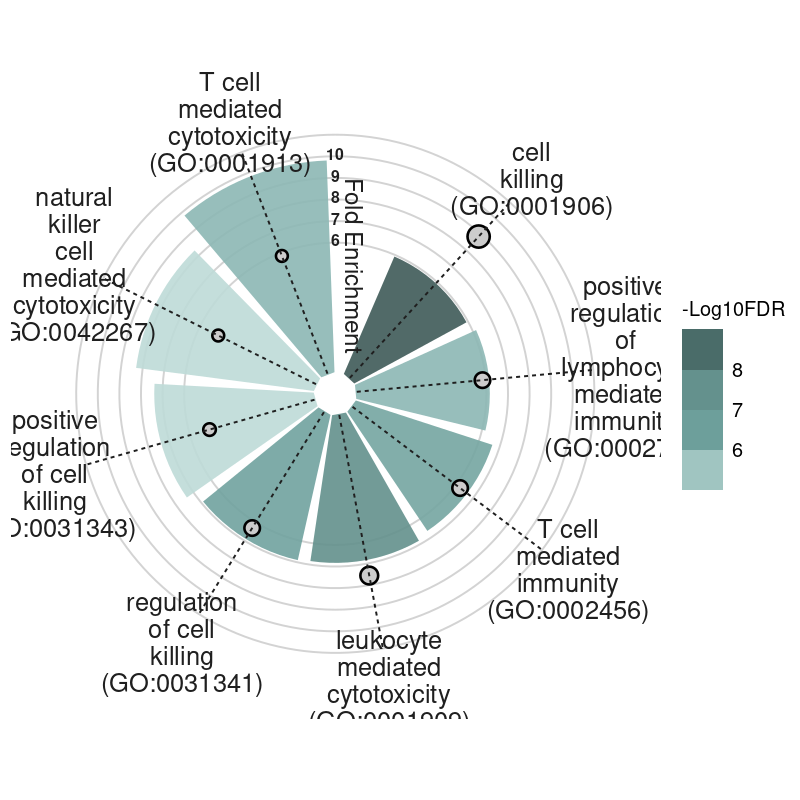

Saving 6.67 x 6.67 in image


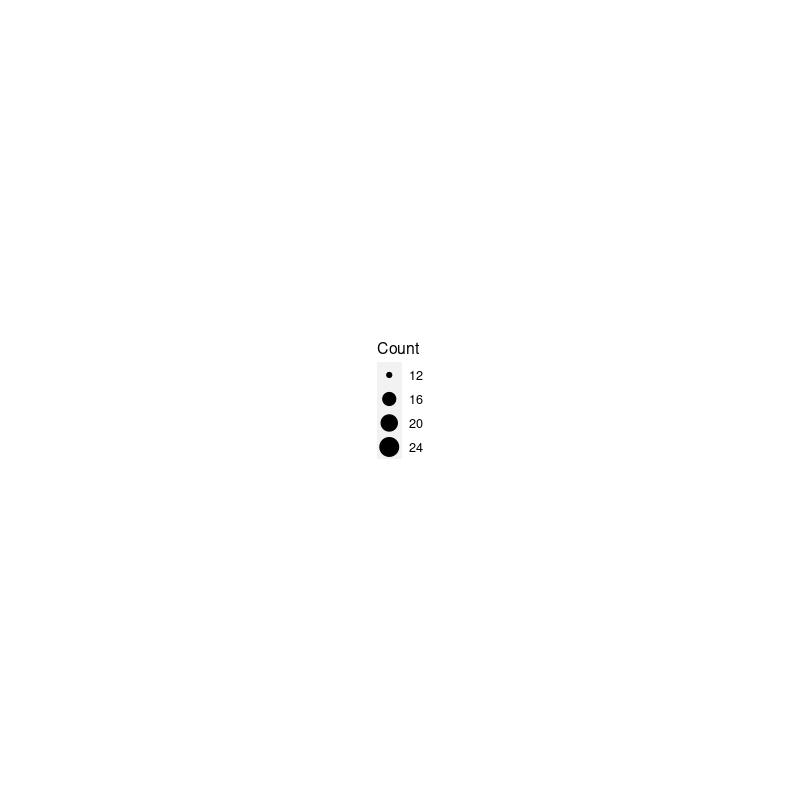

In [39]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100) 
br = c( 6, 7, 8 , 9, 10, 11 ) 
plt <- ggplot(plot_df) +
  # Make custom panel grid
  geom_hline(
    aes(yintercept = y), 
    data.frame(y = br),#c(0:3) * 10),
    color = "lightgrey"
  ) + 
  # Add bars to represent the cumulative track lengths
  # str_wrap(region, 5) wraps the text so each line has at most 5 characters
  # (but it doesn't break long words!)
  geom_col(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = fold.enrichment,
      fill = Log10FDR
    ),
    position = "dodge2",
    show.legend = TRUE,
     alpha = .9
  ) +
  
  # #Add dots to represent the mean gain
  geom_point(color='black',  fill = 'grey80',stroke = 1,pch = 21,
    aes(
        
      x = reorder(str_wrap(region, 10), fold.enrichment ),
      y = Log10FDR
    ),
      
    #size = 3,
      size = plot_df$Count/4,
    # color = "gray12",
     
  ) +
  
  # Lollipop shaft for mean gain per region
  geom_segment(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = 0,
      xend = reorder(str_wrap(region, 10), fold.enrichment),
      yend = 11
    ),
    linetype = "dashed",
    color = "gray12"
  ) + 
  # Make the guide for the fill discrete
  guides(
    fill = guide_colorsteps(
      # barwidth = 8, barheight = 2, title.position = "top", title.hjust = .5
         barwidth = 2, barheight = 8, title.position = "top", title.hjust = .5
    )
  ) +
  # Make it circular!
  coord_polar()+
    theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank()
      

  ) 

# plt
p_c <- plt +
  annotate(
    x = 0.2, 
    y = 5,
    label = "Fold Enrichment",
    geom = "text",
    angle = -90,
    color = "gray12",
    size = 6,
    # family = "Bell MT"
  ) +

  # Annotate custom scale inside plot
  annotate(
    x = 0, 
    y = 6.1, 
    label = "6", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
  annotate(
    x = 0, 
    y = 7.1, 
    label = "7", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
    annotate(
        x = 0, 
        y = 8.1, 
        label = "8", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +

    annotate(
        x = 0, 
        y = 9.1, 
        label = "9", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +

    annotate(
        x = 0, 
        y = 10.1, 
        label = "10", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +
    annotate(
        x = 0, 
        y = 11.1, 
        label = "11", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +

  

    scale_y_continuous(
        limits = c(-1, 11),
        expand = c(0, 0),
        breaks = c(  7, 8 , 9, 10, 11 ) 
      ) +
# #   #New fill and legend title for number of tracks per region
  scale_fill_gradientn(
    "-Log10FDR",
     # colours = c("#d2d9d2", "#a6b4a6", "#798f79", "#607560", "#404e40" )#"#9ca897", '#5d6958', "#6b836b", "#72916a")#"#6C5B7B","#C06C84","#F67280","#F8B195")
      colours = c("#bddad7","#6fa29e","#63908c","#3e5a58")
  ) +

  # Scale y axis so bars don't start in the center
  theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank(),
  legend.title=element_text(size=14),
  legend.text=element_text(size=14)
  ) 

# pdf(file = "Figures/bp_up.pdf",  bg = "transparent", width = 8, height= 8)#, res = 50)   

# dev.off()
p_c
ggsave(
  'Figures/Fig5D.pdf',
  plot = p_c)

p <- ggplot(plot_df, aes(fold.enrichment, Log10FDR))
p <- p + geom_point(aes(size = Count))

library(cowplot)
my_legend <- get_legend(p)

library(ggpubr)
as_ggplot(my_legend)
ggsave(
  'Figures/Fig5D_legend.pdf',
  plot = last_plot())



## GRAPH 

In [40]:
de_genes_list <- rbind(fcvals_down, fcvals_up)
de_genes_list['mgi_symbol'] <- annot[rownames(de_genes_list), 'ensembl_gene_id']
genelist <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist) <- NULL
names(genelist)[1] <- "ID"
dim(genelist)

go_all <- enrichGO(genelist$ID, 
                    OrgDb = "org.Mm.eg.db", 
                    keyType       = 'ENSEMBL',
                    ont           = "all",
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.05,
                    minGSSize = 10, 
                    maxGSSize = 250,
                    universe = annot[ rownames(lcpm),'ensembl_gene_id'],
                    readable      = TRUE
                    )

 
ego <- filter(go_all, ONTOLOGY == 'BP') 
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))

process <- c( 'T cell mediated cytotoxicity', 'T cell mediated immunity','leukocyte mediated cytotoxicity',
            'positive regulation of cell killing', 'positive regulation of leukocyte mediated immunity')
edox = filter(edox, Description %in% process) 

saveRDS(edox, "Supplementary/edox.rds")


[1] 886   7